In [1]:
# %load timetable_db_prep.py


import pandas as pd
import os
import glob

directory = input("Please enter location of the timetable csv files: ")
# os.chdir('/home/mike/wifiproj/data') # change to directory where file is located

os.chdir(directory)

timetables = glob.glob(directory + '/' + '*_ready.csv') # finds all files ending in _ready.csv
for t in timetables:
    print(t)

cleantables = [] # make new list to store the names of cleaned tables;
                # this is needed for using pd.concat later on to join them end to end


for timetable in timetables:

    df = pd.read_csv('{}'.format(timetable)) # read the timetable

    df = df.ix[:9, :11] # cut out unneeded rows and columns
                        # not flexible; what if the structure changes?
                        # could be replaced with regex or something; not sure


# make the dataframes for each day; all identical

    mon_df = pd.DataFrame(index = range(10), columns=['Time', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students'])

    tue_df = pd.DataFrame(index = range(10), columns=['Time', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students'])

    wed_df = pd.DataFrame(index = range(10), columns=['Time', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students'])

    thu_df = pd.DataFrame(index = range(10), columns=['Time', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students'])

    fri_df = pd.DataFrame(index = range(10), columns=['Time', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students'])


    # make list to use pd.concat
    day_tables = [mon_df, tue_df, wed_df, thu_df, fri_df]


    column = 1 # counter for controlling the column to take values from

    for table in day_tables:
        table.Time = df[[0]].ix[1:]
        table.Module = df[[column]].ix[1:]
        table.Registered_Students = df[[column+1]].ix[1:]
        room = df.columns[0]
        csroom = 'CS' + room
        table.Room= csroom
        table.Room_Capacity = df.columns[2].split(' ')[2]
        # date. changeable
        column += 2

    del column # clean column for subsequent loops


    df = pd.concat(day_tables) # join all daytables into one dataframe

    df = df[df.Time.notnull()] # remove any rows where there is no time value

    two_weeks = [df, df] # make list to duplicate timetable for second week

    df = pd.concat(two_weeks) # join these together

    date_index = pd.date_range('2015-11-2', periods=12, freq='D') # create date range


    # this loop assigns every row a date
    day = 0
    count = 0

    while count < df.shape[0]: # while less than no. of rows
        df.iat[count,1] = date_index[day] #

        if (count + 1)% 9 == 0:     # every nine rows, increment the day
            day += 1                # assumes 9 timeslots per day (9 - 17)

            if day == 5:            # skip the weekend days once you hit friday
                day += 2            # error if: not scalable to longer than two weeks

        count += 1

    # this loop assigns a value to 'module' and 'registered_students' if 'module' == NaN
    # error: doesn't modify for some modules that don't have registered students
    # see B004, leaves some 'reg_students' columns as NaN
    count = 0

    while count < df.shape[0]:
        if pd.isnull(df.iat[count,4]): # if module value is NaN
            df.iat[count,4] = 'Vacant'
            df.iat[count,5] = 'Vacant'

        count += 1

    cleantables.append(df) # append this df to clean_tables; needed for pd.concat


df_finish = pd.concat(cleantables)
df_finish.reset_index(drop=True) # reset the index of the joined tables

#keep only first two characters in Time
for item, frame in df_finish['Time'].iteritems():
    df_finish['Time'] = df_finish['Time'].map(lambda x: str(x)[:2])

#remove : from time
for item, frame in df_finish['Time'].iteritems():
    df_finish['Time'] = df_finish['Time'].map(lambda x: x.lstrip(':').rstrip(':'))

#retain only first 10 characters in date
for item, frame in df_finish['Date'].iteritems():
    df_finish['Date'] = df_finish['Date'].map(lambda x: str(x)[:10])

df_finish.to_csv('timetable_table.csv', index=False) # convert df to .csv, drop the index

roomtable = df[['Room', 'Room_Capacity']] # create table according to DB schema
modtable = df[['Module', 'Registered_Students']] # create table according to DB schema

roomtable.to_csv('room_table.csv', index=False) # convert df to .csv, drop the index
modtable.to_csv('mod_table.csv', index=False) # convert df to .csv, drop the index

classtable = df[['Room', 'Module', 'Date', 'Time']] # create table according to DB schema
classtable.to_csv('class_table.csv', index=False) # convert df to .csv, drop the index


Please enter location of the timetable csv files: /Users/shauna/Desktop/
/Users/shauna/Desktop/B0.02_ready.csv
/Users/shauna/Desktop/B0.03_ready.csv
/Users/shauna/Desktop/B0.04_ready.csv


In [2]:
def set_identifier(df):    
    room_index = df.columns.get_loc("Room")
    date_index = df.columns.get_loc("Date")
    hour_index = df.columns.get_loc("Hour")
    id_index = df.columns.get_loc("ID")

    for row in range(df.shape[0]):
       hour = str(df.iat[row, hour_index])
       date = str(df.iat[row, date_index])
       room = str(df.iat[row, room_index])

       identifier = str(hour + date + room)

       df.iat[row, id_index] = identifier

In [3]:
#log cleaning
import pandas as pd
import datetime
df = pd.read_csv('/Users/shauna/Desktop/Wifinder/WiFinder/Data/results.csv')
#create titles for the columns
df.columns = ["Room", "DateTime", "Associated_count", "Authenticated_count"]
#create 2 empty columns
df['Building'] = ""
df['Campus'] = ""
#split the Room column into 3 seperate columns and getting reformatting room
for i in range(df.shape[0]):
    value = df.iat[i, 0]
    list = value.split('> ')
    building = list[1]
    Campus = list[0]
    good_room = list[2].replace('-', '')
    df.iat[i, 0] = good_room
    df.iat[i, 4] = building
    df.iat[i, 5] = Campus
#convert DateTime column to datetime format and only keeping the date
#creating time column from datetime column and only keeping the time
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Time'] = df['DateTime']
df['DateTime'] = df['DateTime'].apply(lambda x: x.date())
df['Time'] = df['Time'].apply(lambda x: x.time())
#creating hour column and only keeping two digits
df["Hour"] = df["Time"]
df["Hour"] = df["Hour"].map(lambda x: str(x)[:2])
#renaming columns
df.columns = ['Room', 'Date', 'Associated_count', 'Authenticated_count', 'Building', 'Campus', 'Time', 'Hour']
#create an empty ID column and call function to ceate unique ID for each row
df['ID'] = ""
set_identifier(df)
#save as csv
df.to_csv('/Users/shauna/Desktop/logdata_table.csv', index=False)

In [4]:
df.head()

,Room,Date,Associated_count,Authenticated_count,Building,Campus,Time,Hour,ID
0,B002,2015-11-02,0,0,Computer Science,Belfield,20:37:10,20,202015-11-02B002
1,B002,2015-11-02,0,0,Computer Science,Belfield,20:42:12,20,202015-11-02B002
2,B002,2015-11-02,0,0,Computer Science,Belfield,20:47:14,20,202015-11-02B002
3,B002,2015-11-02,0,0,Computer Science,Belfield,20:52:11,20,202015-11-02B002
4,B002,2015-11-02,0,0,Computer Science,Belfield,20:57:11,20,202015-11-02B002


In [5]:
#timetable cleaning
#get rid of . and CS in Room column
df_finish['Room'] = df_finish['Room'].str.replace('.', '')
df_finish['Room'] = df_finish['Room'].str.replace('CS', '')
#rename columns
df_finish.columns = ['Hour', 'Date', 'Room', 'Room_Capacity', 'Module', 'Registered_Students']
#create an empty ID column and call function to ceate unique ID for each row
df_finish['ID'] = ""
set_identifier(df_finish)
#save as csv
df_finish.to_csv('/Users/shauna/Desktop/timetable_table.csv', index=False)

In [6]:
df_finish.tail()

,Hour,Date,Room,Room_Capacity,Module,Registered_Students,ID
5,13,2015-11-13,B004,220,COMP20110,103,132015-11-13B004
6,14,2015-11-13,B004,220,COMP10110,113,142015-11-13B004
7,15,2015-11-13,B004,220,COMP30220,38,152015-11-13B004
8,16,2015-11-13,B004,220,Vacant,Vacant,162015-11-13B004
9,17,2015-11-13,B004,220,Vacant,Vacant,172015-11-13B004


In [7]:
#csi cleaning
csi = pd.read_csv("/Users/shauna/Desktop/occupancy_table.csv")
#convert Date to datetime format
csi['Date'] = pd.to_datetime(csi['Date'])
#keep only first 2 characters in time column and remove .
csi['Time'] = csi['Time'].map(lambda x: str(x)[:2])
csi['Time'] = csi['Time'].map(lambda x: x.lstrip('.').rstrip('.'))
#only keep date in Date column
csi['Date'] = csi['Date'].apply(lambda x: x.date())
#rename columns
csi.columns = ['Hour','Date','Room','Occupancy']
#create an empty ID column and call function to ceate unique ID for each row
csi['ID'] = ""
set_identifier(csi)
#sava as csv
csi.to_csv("/Users/shauna/Desktop/occupancy_table_final.csv", index=False)

In [8]:
csi.head()

,Hour,Date,Room,Occupancy,ID
0,9,2015-11-02,B002,0.25,92015-11-02B002
1,10,2015-11-02,B002,0.50,102015-11-02B002
2,11,2015-11-02,B002,0.25,112015-11-02B002
3,12,2015-11-02,B002,0.25,122015-11-02B002
4,13,2015-11-02,B002,0.50,132015-11-02B002


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111c867b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117b99358>]], dtype=object)

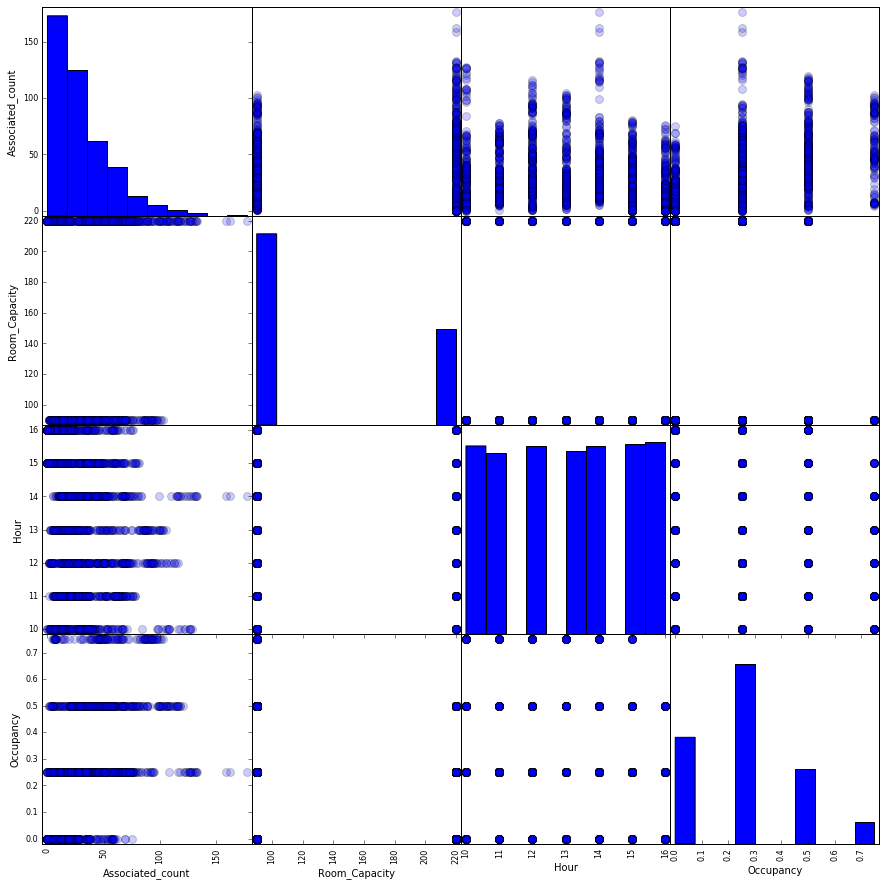

In [13]:
#merged datframe
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
timetable = pd.read_csv('/Users/shauna/Desktop/Wifinder/WiFinder/Data/final_csvs/timetable_table.csv')
log = pd.read_csv('/Users/shauna/Desktop/Wifinder/WiFinder/Data/final_csvs/logdata_table.csv')
csi = pd.read_csv('/Users/shauna/Desktop/Wifinder/WiFinder/Data/final_csvs/occupancy_table_final.csv')
f_df =pd.merge(log, timetable,left_on='ID', right_on='ID', how="inner")
df =pd.merge(f_df, csi,left_on='ID', right_on='ID', how="inner")
del df['Hour_x']
del df['Hour_y']
del df['Date_x']
del df['Date_y']
del df['Room_x']
del df['Room_y']
del df['Authenticated_count']
del df['Campus']
del df['Building']
del df['ID']
df.to_csv("/Users/shauna/Desktop/merged_table.csv", index=False)
scatter_matrix(df, figsize=(15, 15), alpha=0.2, diagonal='hist', s=250)

In [ ]:
df.Hour.max()

In [ ]:
df.Hour.min()